In [1]:
include("settings.jl")

  Activating project at `~/Documents/Github/LocomotionControl`


[05/04/23 16:02:07] DEBUG    Connected to database: loco_data     __init__.py:11


[2023-05-04 16:02:05,924][INFO]: Connecting root@127.0.0.1:3306
[2023-05-04 16:02:05,968][INFO]: Connected root@127.0.0.1:3306


## Plot Ephys Raw data

Plot things like bout-aligned spike rasters etc.

In [2]:
bouts = convert(DataFrame, py"get_bouts('outbound', baseline=False, target='MOs')");

## Break down the number of MOs units and trials per recording per mouse

In [3]:
using Term.Tables

recs = bouts.name |> unique
metadata = Dict(:mouse => [], :rec=>[], :n_bouts=>[], :n_units=>[])

for rec in recs
    rec_bouts = bouts[bouts.name .== rec, :]
    add_activity_to_bouts!(rec_bouts, target="MOs")
    units = filter(col -> occursin("unit_", col), names(rec_bouts))
    mouse = split(rec, "_")[3]

    push!(metadata[:mouse], mouse)
    push!(metadata[:rec], rec)
    push!(metadata[:n_bouts], size(rec_bouts, 1))
    push!(metadata[:n_units], length(units))

end

Table(metadata;) |> println

               ╷           ╷           ╷                                 
     mouse     │  n_bouts  │  n_units  │              rec                
╺━━━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸
   BAA0000012  │    11     │     0     │  FC_220207_BAA0000012_hairpin   
╶──────────────┼───────────┼───────────┼────────────────────────────────╴
   BAA0000012  │    15     │     0     │  FC_220211_BAA0000012_hairpin   
╶──────────────┼───────────┼───────────┼────────────────────────────────╴
   BAA0000012  │     1     │    13     │  FC_220213_BAA0000012_hairpin   
╶──────────────┼───────────┼───────────┼────────────────────────────────╴
   BAA0000012  │    11     │     0     │  FC_220217_BAA0000012_hairpin   
╶──────────────┼───────────┼───────────┼────────────────────────────────╴
   BAA0000012  │     6     │     0     │  FC_220220_BAA0000012_hairpin   
╶──────────────┼───────────┼───────────┼────────────────────────────────╴
   BAA1101192  │    12     │     0    

## Raster plots & heatmaps


In [4]:
# keep only recordings with enough bouts and units
metadata = DataFrame(metadata)
to_analyze = filter(row -> row.n_bouts >= 5 && row.n_units >= 5, metadata)
to_analyze

9×4 DataFrame
 Row │ mouse       n_bouts  n_units  rec                          
     │ Any         Any      Any      Any                          
─────┼────────────────────────────────────────────────────────────
   1 │ BAA1101192  14       24       FC_220410_BAA1101192_hairpin
   2 │ BAA1101192  6        42       FC_220412_BAA1101192_hairpin
   3 │ BAA1101192  12       55       FC_220413_BAA1101192_hairpin
   4 │ BAA1101192  25       19       FC_220414_BAA1101192_hairpin
   5 │ BAA1101192  40       52       FC_220415_BAA1101192_hairpin
   6 │ BAA1101192  15       40       FC_220432_BAA1101192_hairpin
   7 │ BAA1101192  5        47       FC_220433_BAA1101192_hairpin
   8 │ BAA1101192  14       74       FC_220434_BAA1101192_hairpin
   9 │ BAA1101192  28       42       FC_220435_BAA1101192_hairpin

In [349]:
rec = to_analyze.rec[9]
data = bouts[bouts.name .== rec, :]
add_activity_to_bouts!(data, target="MOs", bw=200)

unit_names = filter(col -> occursin("unit_", col), names(data));
# s, X, Y, S, A, T, D = stack_kinematic_variables(data);
nothing

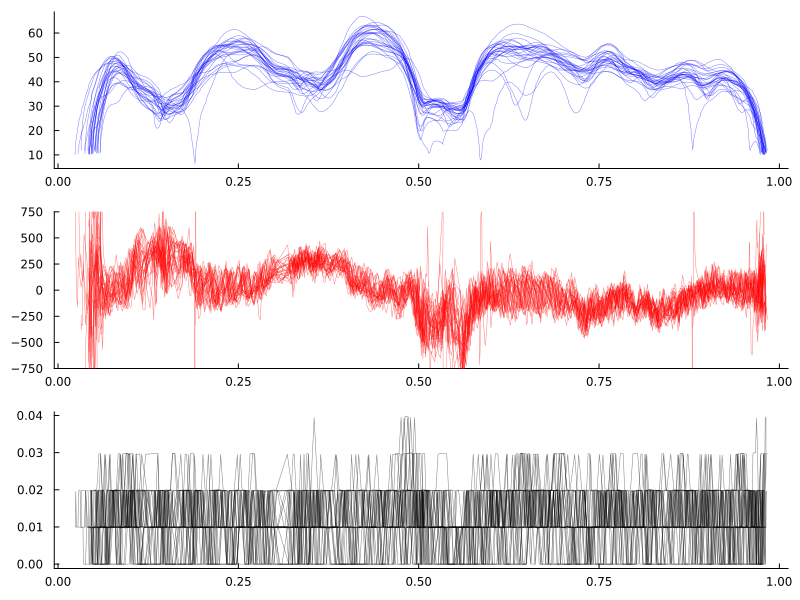

In [350]:

for unit in unit_names
    speed  = plot(grid = false)
    angvel = plot(grid = false, ylim=[-750, 750])
    activity = plot(grid = false)

    for bout in eachrow(data)

        t = range(0, 1, length(bout.speed))

        plot!(speed, bout.s, bout.speed, color=:blue, linewidth=0.5, alpha=0.5, label=nothing)
        plot!(angvel, bout.s, bout.angvel, color=:red, linewidth=0.5, alpha=0.5, label=nothing)
        plot!(activity, bout.s, bout[unit], color=:black, linewidth=0.5, alpha=0.5, label=nothing)
    end

    plt = plot(speed, angvel, activity, layout=(3, 1), size=(800, 600), rowheights=[0.2, 0.2, 0.6];)
    display(plt)
    # savefig(plt, "$(savefig_fld)/$(rec)_$(unit)_activity_overview.png")

    break
end

## ISOMAP & PCA

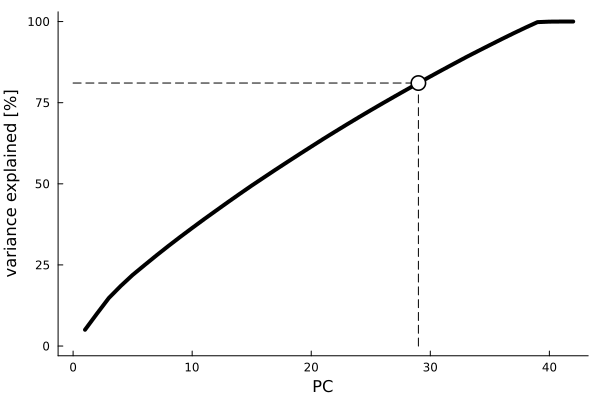

In [351]:
s_stop = .8
cols = ["s", "speed", "acceleration", "angvel", "angaccel", unit_names...]

stop(t) = findfirst(t[:, 1] .> s_stop)

trials = map(r -> hcat(r...), eachrow(data[:, cols]))
trials = map(trial -> trial[1:stop(trial), :], trials)

X = vcat(trials...)' |> Matrix  # matrix of size N×T

s = X[1, :]
S = X[2, :]
A = X[3, :]
T = X[4, :]
D = X[5, :]
X = X[6:end, :]

normalizer = fit(ZScoreTransform, X, dims = 2)  # normalize rows
X = transform(normalizer, X)


# do PCA to reduce to 10 dimensions
model = fit(PCA, X,  pratio = 1)

v = fraction_variance_explained(model) |> cumsum
v_th = findfirst(v .> 80)
plot(v, linewidth=4, color=:black, label=nothing, xlabel="PC", ylabel="variance explained [%]", grid=false, legend=false)
plot!([0, v_th], [v[v_th], v[v_th]], linewidth=1, ls=:dash, color=:black, label=nothing)
plot!([v_th, v_th], [0, v[v_th]], linewidth=1, ls=:dash, color=:black, label=nothing)
scatter!([v_th], [v[v_th]], markersize=8, color=:white, msc=:black, msw=2, label=nothing)


In [352]:
model = fit(PCA, X, maxoutdim = v_th, pratio = 1)
PC = predict(model, X)

iso = ManifoldLearning.fit(
    Isomap,
    PC[:, 1:10:end];
    k = 12,
    maxoutdim = 3
)
M = predict(iso, PC);


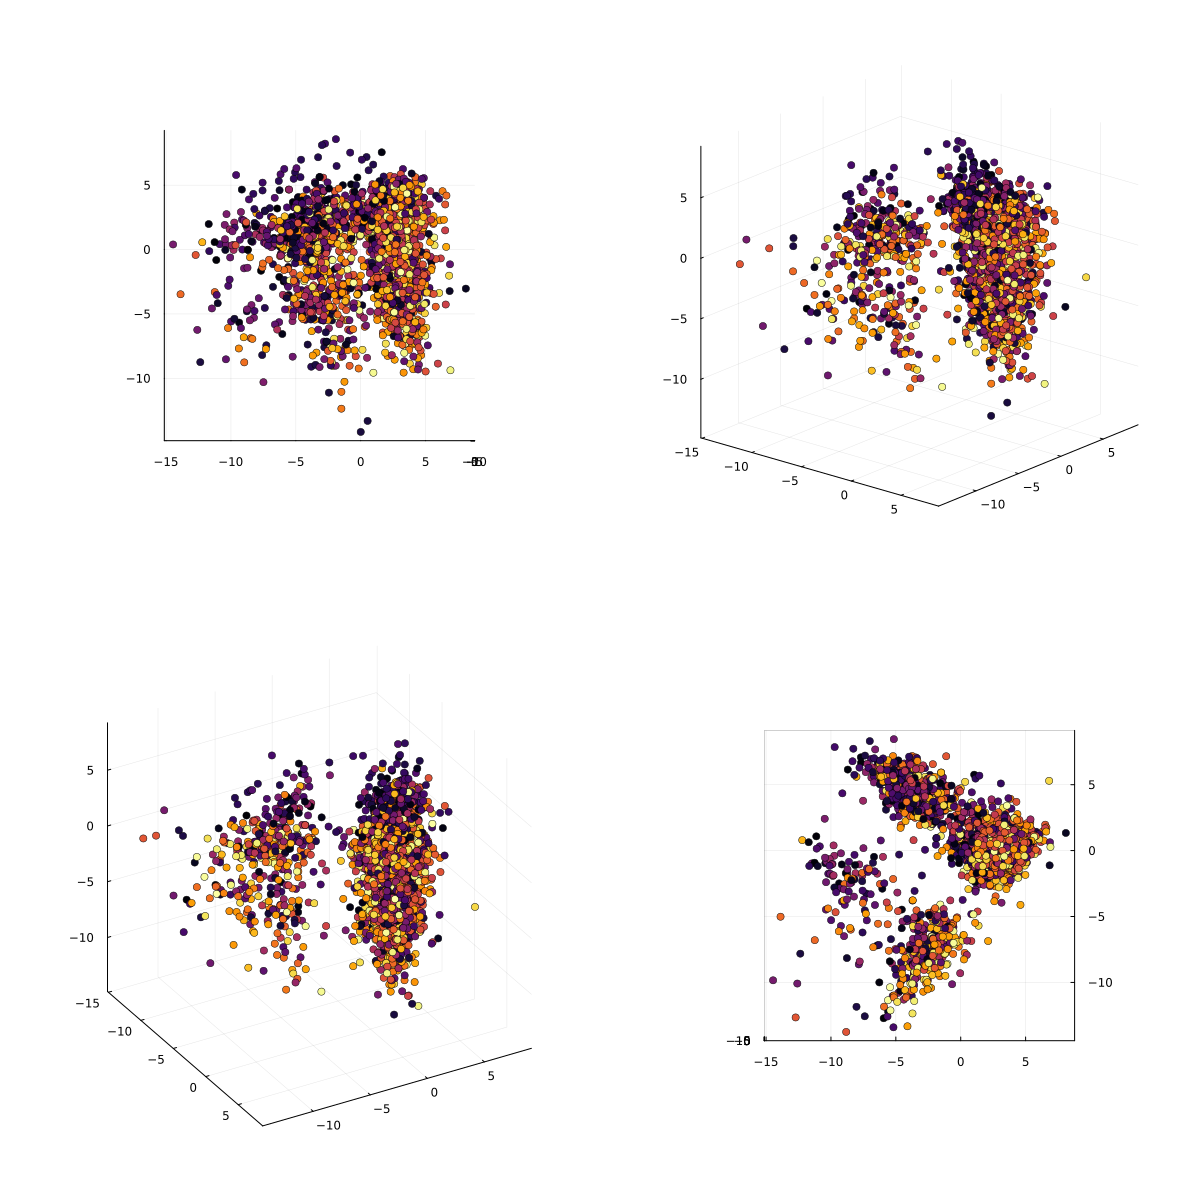

In [354]:

plots = []
cameras = [
    (0, 0),
    (40, 20),
    (60, 30),
    (0, 90)
]
Δ = 3


for cam in cameras
    push!(plots, scatter(eachrow(M[:, 1:Δ:end])..., 
        marker_z=s[1:Δ:end], #clims=(-400, 400),
        camera=cam, colorbar=false, msw=0.2, msa=0.5, ms=4, label=nothing, 
        )
        )
end

plt = plot(plots..., layout=(2, 2), size=(1200, 1200),)